In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from scipy.signal import savgol_filter
x = np.array([1.,2.,3.,5.,5.,6.,3.])
savgol_filter(x,window_length=5, polyorder=1)

array([ 1. ,  2.1,  3.2,  4.2,  4.4,  4.5,  4.6])

In [3]:

def smooth(x, smooth_cycles=31,smooth_order=2):
    smooth_order = min(2,smooth_cycles-1)
    return savgol_filter(x,smooth_cycles,smooth_order)

# slope that averages the left slope and right slope of x vs t
def slope(x,t):
    x = np.array(x)
    t = np.array(t)
    s = (x[1:] - x[0:-1]) / (t[1:] - t[0:-1])
    
    r_slope = np.append(s,s[-1])
    l_slope = np.append(s[0], s)
    
    return (r_slope+l_slope)/2.

#test slope
x = np.array([1.,2.,3.,5.,5.])
t = np.array([0.,2.,3.,4.,5.])
print 'slope test returend: ',slope(x,t)

slope test returend:  [ 0.5   0.75  1.5   1.    0.  ]


In [4]:
# making a class like this makes it easy to 
# create ad-hoc objects and set late bound
# properties
class Object:
    pass

import os

results = []
data_folder = "../python/data/esc"
for filename in sorted(os.listdir(data_folder)):
    o = Object()
    o.filename = filename
    file_path = os.path.join(data_folder,filename)
    o.data = pd.read_csv(file_path)
    results.append(o)

print results[0].data.head()

    seconds    meters          us   esc  odometer_ticks    ax  spur_delta_us  \
0  0.000000  0.000000  4052130373  1765              52  1.54          72169   
1  0.010005  0.006822  4052140378  1500              54  1.38          72169   
2  0.020005  0.017055  4052150378  1500              57  1.32          72169   
3  0.030000  0.027288  4052160373  1500              60  1.35          72169   
4  0.040011  0.040932  4052170384  1500              64  1.68          72169   

   spur_odo  
0      3140  
1      3140  
2      3140  
3      3140  
4      3140  


In [5]:
def big_plot():
  plt.figure(figsize=(15,10))

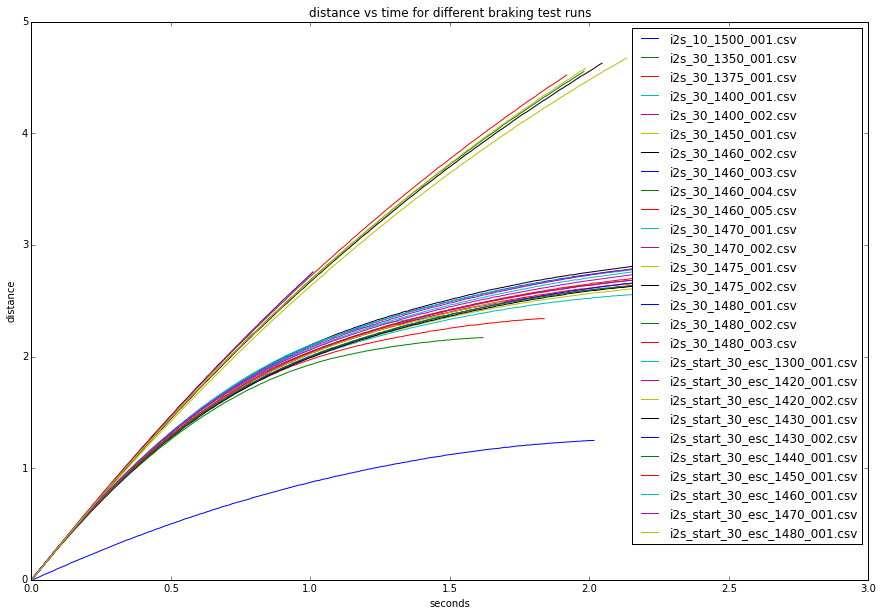

In [6]:
big_plot()
for r in results:
  plt.plot(r.data.seconds,r.data.meters,label=r.filename)

plt.xlabel('seconds')
plt.ylabel('distance')
plt.title('distance vs time for different braking test runs')
plt.legend(loc='best')
plt.show()

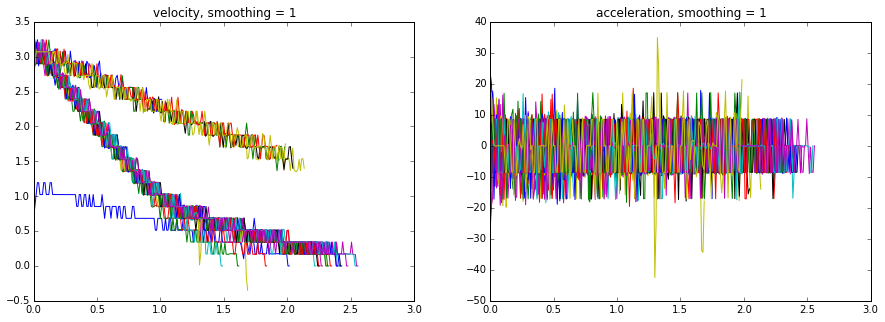

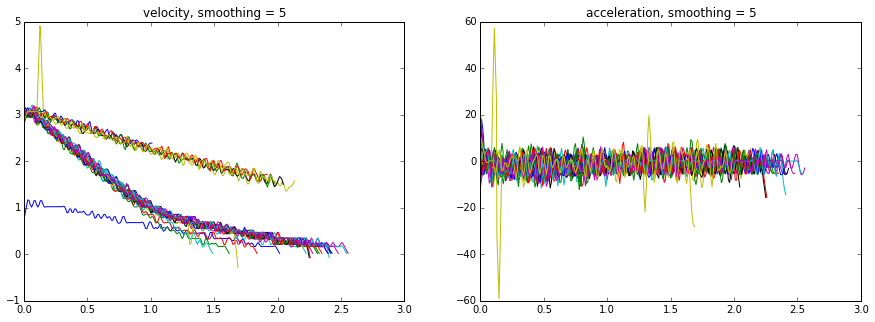

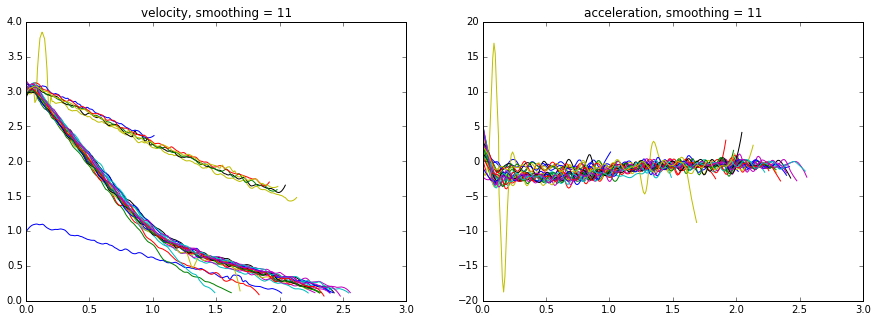

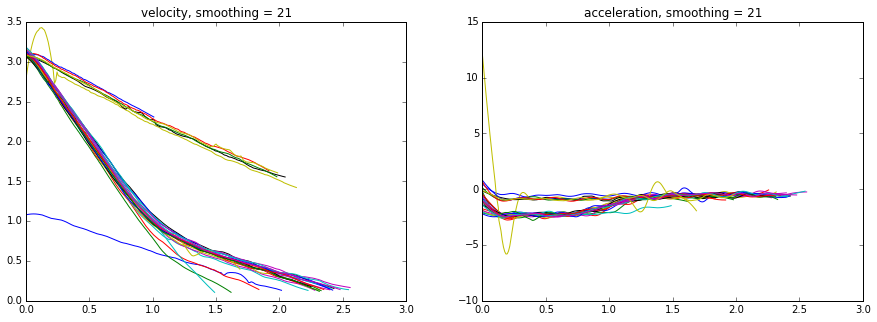

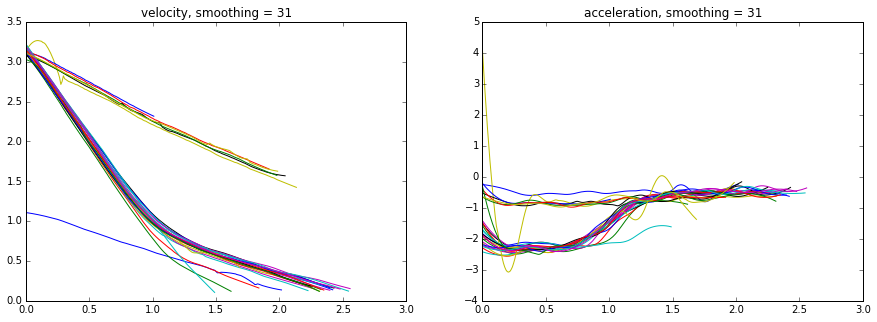

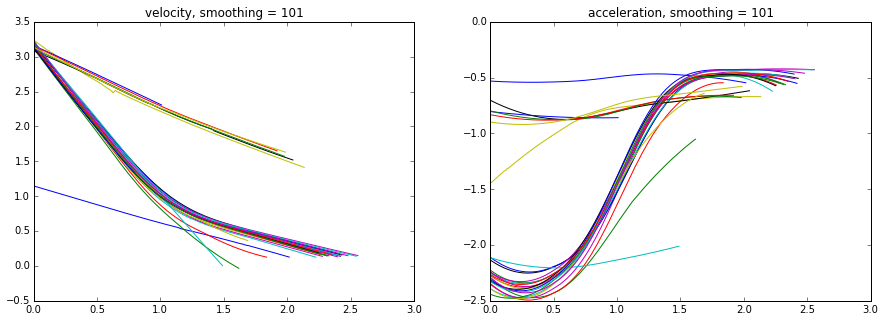

In [7]:
for bin_width in [1,5,11,21,31,101]:
    plt.figure(figsize=(15,5))
    # plot velocities
    plt.subplot(121)
    for r in results:
        d = r.data
        smooth_meters = smooth(d.meters,bin_width)
        v = slope(smooth_meters,d.seconds)
        v_smooth = smooth(v,bin_width)
        plt.plot(d.seconds,v_smooth)
    plt.title('velocity, smoothing = {}'.format(bin_width))

    # plot accelerations
    plt.subplot(122)
    for r in results:
        d = r.data
        smooth_meters = smooth(d.meters,bin_width)
        v = slope(smooth_meters,d.seconds)
        v_smooth = smooth(v,bin_width)
        a_smooth = smooth(slope(v_smooth,d.seconds),bin_width)
        plt.plot(d.seconds,smooth(a_smooth,bin_width))
    plt.title('acceleration, smoothing = {}'.format(bin_width))
    plt.show()

  

In [8]:
# calculate v each row of each run
for r in results:
    r.data=r.data[25:] #remove first row with preceding esc: todo fix this in gathering code
    d = r.data
    d['v'] = pd.Series(slope(d.meters,d.seconds),index=d.index)
    d['a'] = pd.Series(slope(d.v,d.seconds),index=d.index)
    
    d['meters_smooth'] = pd.Series(smooth(d.meters),index=d.index)
    d['v_smooth'] = pd.Series(smooth( slope(d.meters_smooth, d.seconds) ),index=d.index)
    d['a_smooth'] = pd.Series(smooth(slope(d.v_smooth,d.seconds)),index=d.index) 
    d['ax_smooth'] = pd.Series(smooth(d.ax),index=d.index)


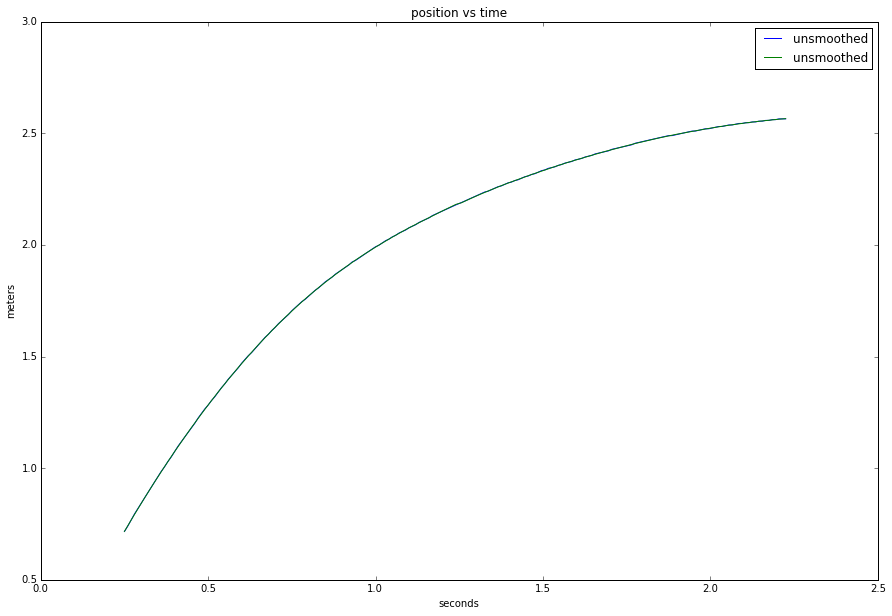

In [9]:
d = results[3].data
big_plot()
plt.title('position vs time')
plt.plot(d.seconds,d.meters,label='unsmoothed')
plt.plot(d.seconds,d.meters_smooth,label='unsmoothed')
plt.xlabel('seconds')
plt.ylabel('meters')
plt.legend(loc='best')
plt.show()

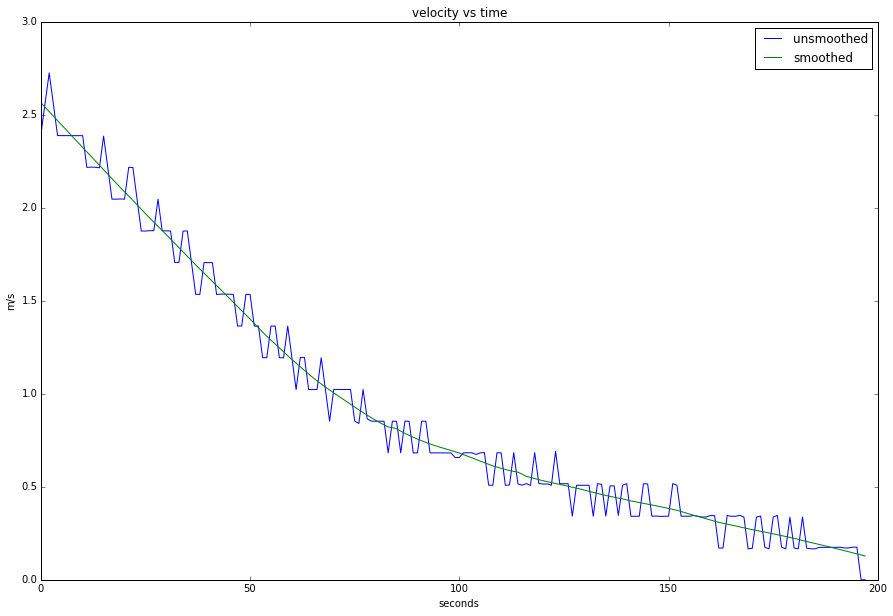

In [10]:
big_plot()
plt.title('velocity vs time')
plt.plot(d.v,label='unsmoothed')
plt.plot(d.v_smooth,label='smoothed')
plt.ylabel('m/s')
plt.xlabel('seconds')
plt.legend(loc='best')
plt.show()

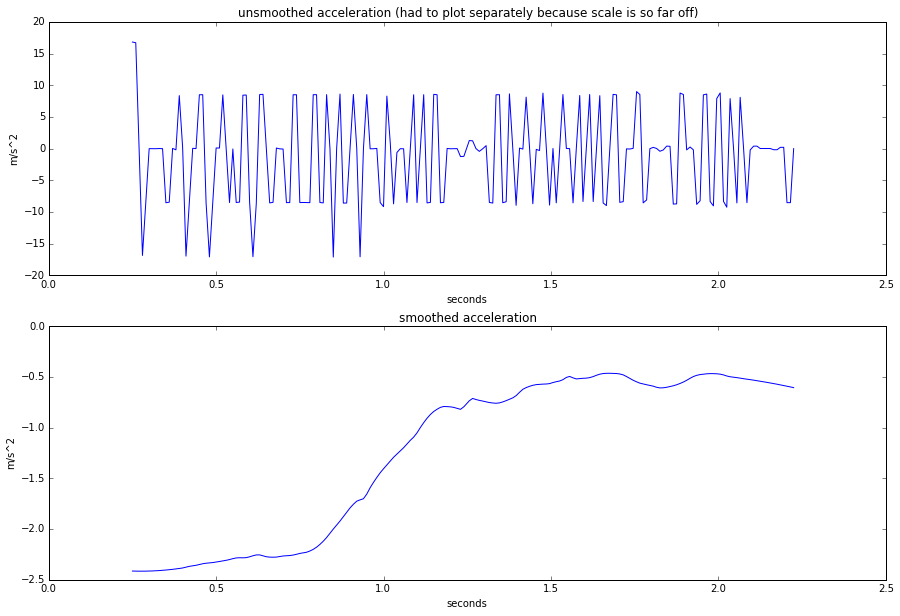

In [11]:
big_plot()
a = slope(d.v,d.seconds)
plt.subplot(211)
plt.title('unsmoothed acceleration (had to plot separately because scale is so far off)')
plt.plot(d.seconds,d.a)
plt.ylabel('m/s^2')
plt.xlabel('seconds')

plt.subplot(212)
plt.title('smoothed acceleration')
plt.ylabel('m/s^2')
plt.xlabel('seconds')
a_smooth = smooth(slope(d.v_smooth,d.seconds))
plt.plot(d.seconds,d.a_smooth)
plt.show()

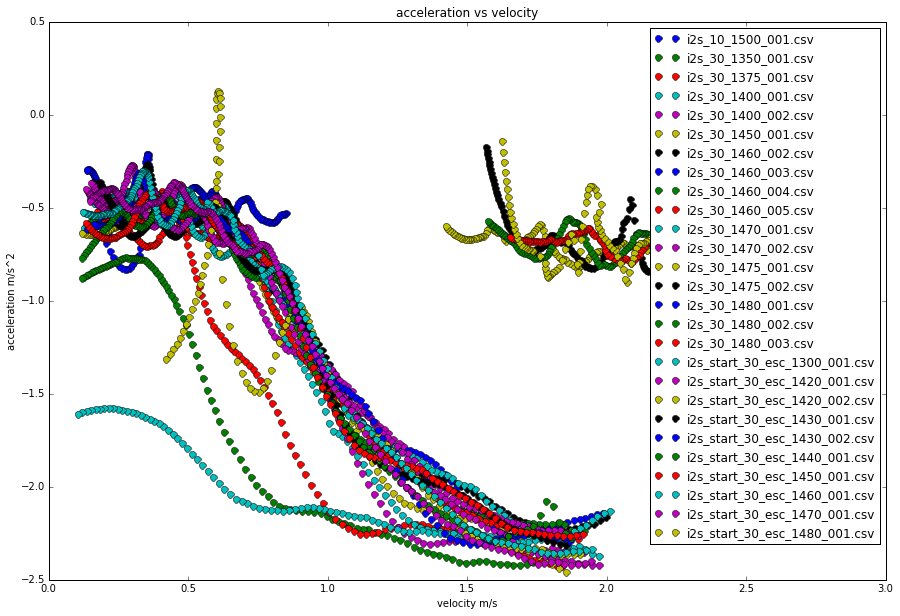

In [12]:
big_plot()
for r in results:
    start_index =30 # change this to about 20 to get start of test / switchover conditions
    d = r.data
    #plt.scatter(d.v_smooth,d.a_smooth,label=r.filename)
    plt.plot(d.v_smooth[start_index:],d.a_smooth[start_index:],label=r.filename, marker='o', linestyle='', ms=7)
    plt.title('acceleration vs velocity')
    plt.xlabel('velocity m/s')
    plt.ylabel('acceleration m/s^2')

plt.legend()
plt.show()

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


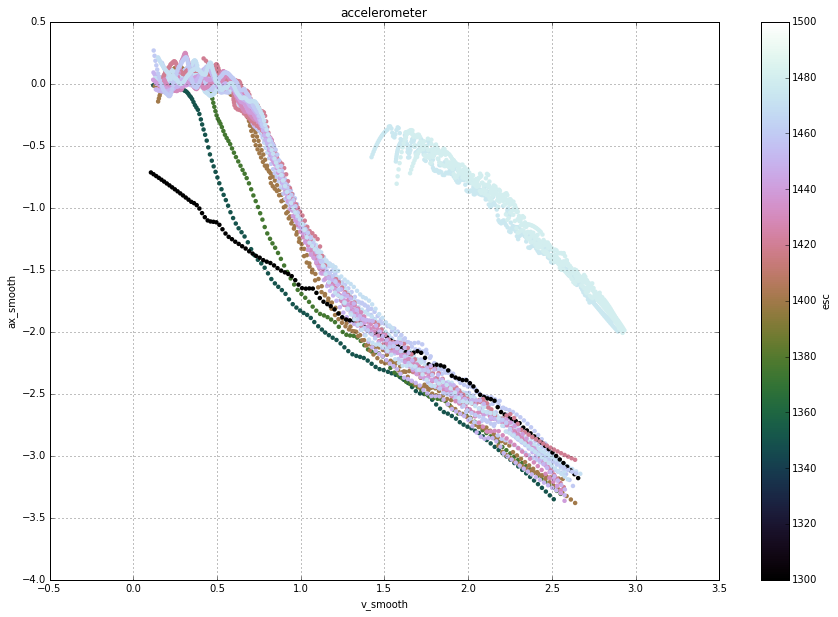

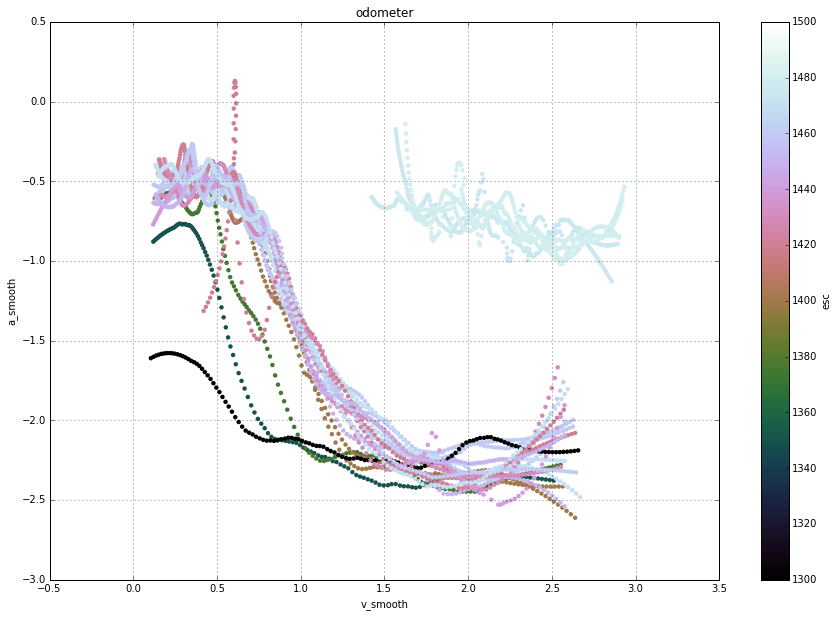

In [13]:
#big_plot()

runs = []
for r in results:
    runs.append(r.data)
df = pd.concat(runs)
df=df[df.esc<=1500]
df.plot(title='accelerometer',kind='scatter',x='v_smooth',y='ax_smooth',c='esc',colormap='cubehelix',edgecolors='none',figsize=(15,10))
plt.show()
df.plot(title ='odometer', kind='scatter',x='v_smooth',y='a_smooth',c='esc',colormap='cubehelix',edgecolors='none',figsize=(15,10))
plt.show()
#plt.show()
#print df.head()
